In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from exp_a4 import A4Factory
from exp_a23 import A23Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct

In [42]:
# number of qubits n, where size of the matrix is 2**n
n = 2
t = 1
# b entry of the matrices
b_4 = 1/3
b_2 = 1/3
# Number of elements in the sum (log_2 k)
n_sum = 3
# number of ancilla qubits for the unitary operations themselves
n_ancilla = n-1
# number of ancilla qubits for controlling the unitary operations
n_a_con = 1
# number of ancilla qubits for multi-controlled toffoli
n_toff = n_sum-2

In [43]:
def uni_matrix_factory(last_column):
    size = np.size(last_column)
    col = last_column.reshape((size, 1))
    a = np.zeros((size, size))

    a[:, [-1]] = col
    for i in range(size-1):
        a[:i+1, [i]] = col[:i+1]
        a[i+1, i] = - sum(col[:i+1]**2) / col[i+1]

    for i in range(size):
        a[:, i] = a[:, i] / np.sqrt(sum(a[:, i]**2))

    a = np.fliplr(a)
    return a

In [44]:
def check_power_of_a(n, a):
    if n == 1:
        return True
    elif n % a == 0:
        n = n / a
        check_power_of_a(n, a)
    else:
        return False

In [45]:
def dec2bin(decimal_number):
    binlist = []
    for i in range(len(bin(decimal_number))-2):
        binlist.append(int(bin(decimal_number)[2+i]))
    return binlist

def permutation_control(qc, q_control_list, i):
    binlist = dec2bin(i)
    for j in range(len(binlist)):
        if binlist[j]==1:
            qc.x(q_control_list[len(binlist)-j-1])

In [55]:
def put_mct():
    if n_toff > 0:
        qc.mct(qr_sum, qrac[0], qrt)
    elif n_sum == 2:
        qc.ccx(qr_sum[0], qr_sum[1], qrac)

In [59]:
# TODO: for sums with more than 2 elements need to change qr[n] by the right index
#quantum register for the matrix
qr = QuantumRegister(n)
qr_sum = QuantumRegister(n_sum)
#ancilla qubits
qra = QuantumRegister(n_ancilla)
qrac = QuantumRegister(n_a_con)
cr = ClassicalRegister(n+n_sum+n_ancilla+n_a_con)
if n_toff > 0:
    qrt = QuantumRegister(n_toff)
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, qrt, cr)
else:
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, cr)

In [60]:
#create unitary operations given its last column {a_j}
a_vector =  np.arange(1, 2**n_sum+1)# a_vector has to be a power of 2
mat_A = uni_matrix_factory(a_vector)
op_A = Operator(mat_A)
op_B = Operator(mat_A.transpose())

In [61]:
# encode coefficient information through A matrix
qc.append(op_A, qr_sum)
qc.barrier()

for i in range(2**n_sum):
    permutation_control(qc, qr_sum, i)
    put_mct()
    # TODO: substitute by suitable exp(iH_jt)
    A4Factory(n).build_controlled(qc, qr, qrac[0], qra, b_4*t)
    put_mct()
    permutation_control(qc, qr_sum, i)
    qc.barrier()

# invert A matrix
qc.append(op_B, qr_sum)

qc.barrier()
# measurement of qr and qr_sum
qc.measure(qr, cr[0:n])
qc.measure(qr_sum, cr[n:n+n_sum])

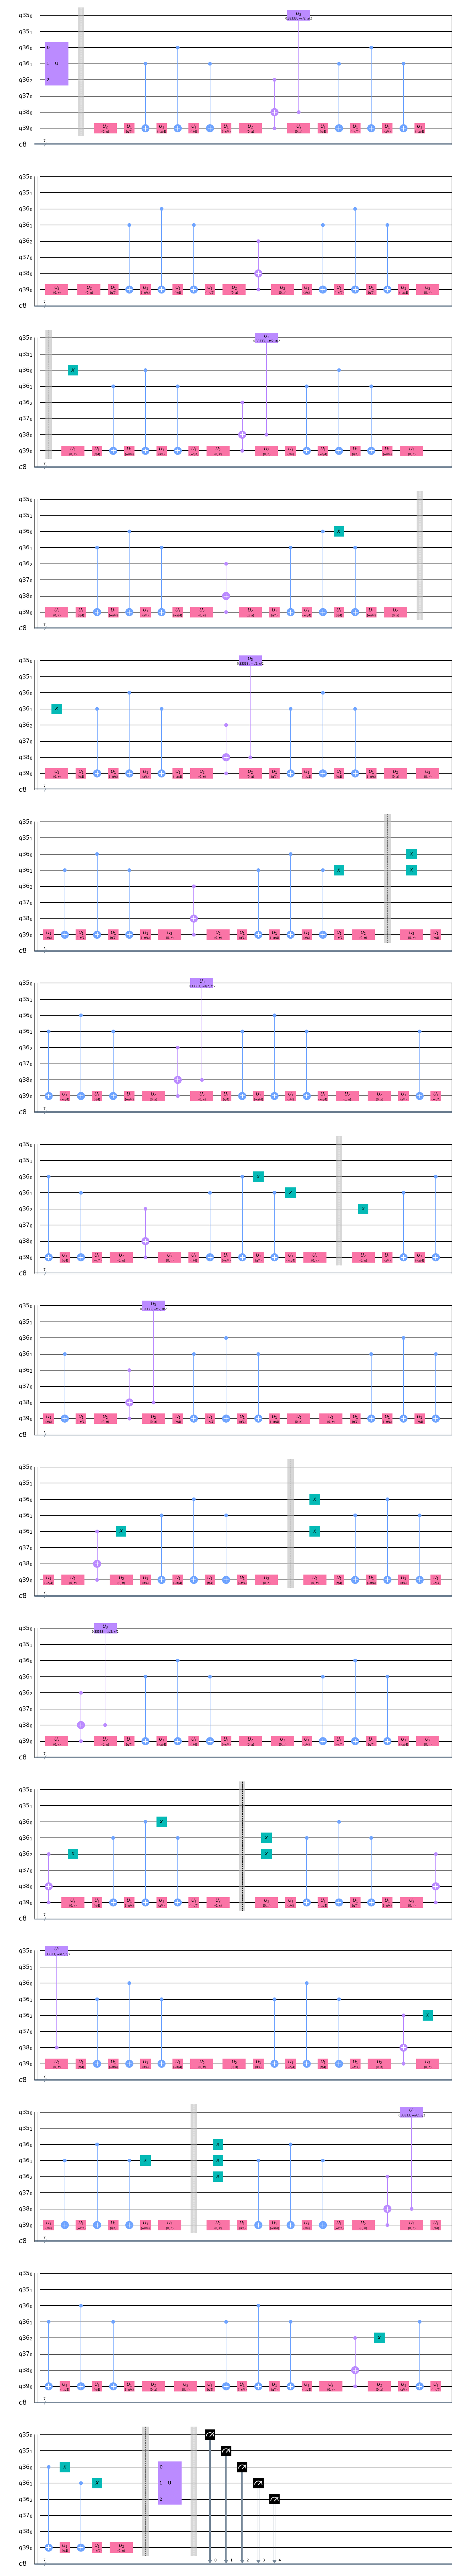

In [62]:
qc.draw(output='mpl')

In [ ]:
# Optional: send the simulation to ibm's simulator
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')
backend = provider.get_backend('ibmq_qasm_simulator')

In [ ]:
# Obtain vector from the circuit
# backend = BasicAer.get_backend('statevector_simulator')
# Create a Quantum Program for execution 
job = execute(qc, backend)
# and store the result
result = job.result()
# Remember its an...a0qn..q0, where the a's are the ancilla
svect = result.get_statevector(qc)

# total number of qubits in the circuit
lastq = n+n_sum+n_ancilla+n_a_con

formatstr = "{0:0"+str(lastq)+"b}"
# Final vector (i.e. approximate solution of e^iHt |x>)
approx_sol = [0]*(2**n)

totalnorm= 0
for i in range(0, len(svect)):
    # Only consider the entries where the sum qubits are 0 (i.e. successful circuit)
    if formatstr.format(i)[0:n_ancilla+n_sum] == '0'*(n_ancilla+n_sum):
                totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
                current_index = int(formatstr.format(i)[lastq-n:lastq][::-1], 2)
                approx_sol[current_index] += svect[i]
                
approx_sol = approx_sol/np.sqrt(totalnorm)

In [ ]:
# analytical case
H23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
H4 = np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)

exact_exp = expm(1j*(H23+H4)*t)

test = np.dot(exact_exp, np.append(1,[0]*((2**n)-1)))
print(test/np.linalg.norm(test))
print(approx_sol)

In [ ]:
print(svect)